# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #6


*   Youtube Lecture #23-26
*   Written by Seungeun Lee

## 2. Multi-class Classification w/ pre-trained ResNet model
*     Dataset: CIFAR10



*    Reference. https://github.com/Justin-A/DeepLearning101/blob/master/4-5_Load-Pre-trained_Model.ipynb

### Quick Question. This chapter covers concepts and applications of Transfer Learning. Then what's the transfer learning? Google it and write your own answer.

In [ ]:
# Transfer Learning

# 구글링을 통해 나온 정의는 이미 학습된 모델을 Starting Point로 시작하여 다시 학습하는 것
# ResNet이나 Word2Vec 등 유명한 Pre-trained model을 가져다 뒷 부분만 Fine-tuning하여 활용하는 것을 지칭하는 말인 것 같습니다

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# 런타임 - 런타임 유형 변경 - T4 GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.3.1+cu121  Device: cuda


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.Resize((299, 299)),  # For inception
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.Resize((299, 299)),  # For inception
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)


Files already downloaded and verified


In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 299, 299]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


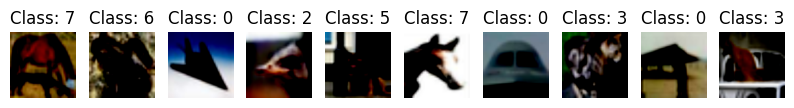

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
import torchvision.models as models
model = models.inception_v3(pretrained = True) # Load ResNet34 model w/ pre-trained weight
print(model) # print the model architecture -- default ResNet34 model (pre-trained w/ Imagenet Dataset) has final 1000 output nodes
# BUT we have 10 classes in CIFAR"10" dataset!! What is CIFAR10?? Check https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html?highlight=cifar for details

# resnet34
# resnet50
# inception_v3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
## IMPORTANT: There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
    parameter.requires_grad = False # We previously learned the requires_grad means utilizing backpropagation

# (2) Updating the weights of the pre-trained models
# for parameter in model.parameters():
#     parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate such CIFAR"10" issue, we should add one more layer having final 10 output nodes
model.fc = nn.Linear(num_ftrs, 10) # Add such layer!

model = model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)

        if isinstance(output, tuple):
                output = output[0]
            # For inception

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)

            if isinstance(output, tuple):
                output = output[0]
            # For inception

            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.334640
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 0.361156
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 0.205532
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 0.239168
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 0.444352
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.129636
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.395570
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.235280

[EPOCH: 1], 	Test Loss: 0.3425, 	Test Accuracy: 88.15 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.192058
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.372475
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.159654
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.262151
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.211091
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.621205
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.412440
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.433985

[EPOCH: 2], 	Test Loss: 0.3410, 	Test Accuracy: 88.06 % 

### Question 1. Compare & Contrast the test result (accuracy) of requires_grad = False & True.


In [ ]:
# requires_grad = false / Do not change pre-trained model
# Accuracy = 47.45%

# requires_grad = true / Change pre-trained model
# Accuracy = 78.86%

# Pre-trained를 재학습 시키는 것이 훨씬 성능이 좋았다
# ResNet의 Pre-trained된 상태가 CIFAR10 Dataset과는 잘 맞지 않았던 것 같다

### Question 2. Change the model ResNet34 to ResNet50 and run the entire code. Compare & Contrast the results of those two models.


In [ ]:
# ResNet34
# Accuracy = 78.86%

# ResNet50
# Accuracy = 80.99%

# Layer 개수가 늘어날수록 성능도 조금씩 좋아진다
# 더 복잡하고 고차원적인 일도 처리할 수 있기 때문

### Question 3. Change the model ResNet34 to Inceptionv3 or v4 and run the entire code. Compare & Contrast the results of those two models.

In [ ]:
# ResNet34
# Accuracy = 78.86%

# Inception_v3
# Accuracy = 88.47%

# Inception은 299x299 image에 맞추어 학습된 모델이라 CIFAR-10을 이에 맞게 Resize 해주고
# 또 Output이 InceptionOutputs라는 Type으로 나오기에 형변환도 맞게 해주어야 한다
# ResNet과 달리 Pre-trained까지 재학습하려면 너무 시간이 걸려 이 부분은 false로 해 주었다

# 복잡한 모델인 만큼 Epoch 1부터 약 88%의 높은 성능을 보였다.
# 그러나 Epoch이 더 진행되어도 별로 늘지 않거나, 오히려 줄어드는 등 88% 근처에만 머물렀다
# 이미 어느정도 완성된 모델이라 더 학습할 여지가 별로 없는 것으로 추측됨
# 여기서 성능을 더 올리려면 CNN관련 기타 Hyperparameter들의 조정이 필요할 것 같음

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment6

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60